In [147]:
import numpy as np
import open3d as o3d
import cv2 as cv
import matplotlib.pyplot as plt
from matplotlib import patches
from tqdm import tqdm
import pickle

In [2]:
pcd = o3d.io.read_point_cloud("../data/driveable_filtered.pcd")

In [3]:
points = np.asarray(pcd.points)

In [8]:
bbox = pcd.get_minimal_oriented_bounding_box()

In [6]:
down_pcd = pcd.voxel_down_sample(0.5)
np.asarray(down_pcd.points).shape

(109385, 3)

In [9]:
abbox = pcd.get_axis_aligned_bounding_box()

In [82]:
abbox

AxisAlignedBoundingBox: min: (-130.983, -183.145, 25.5292), max: (220.122, 109.225, 41.4886)

In [11]:
down_points = np.asarray(down_pcd.points)

In [23]:
top_left = [abbox.min_bound[0], abbox.max_bound[1]]
bottom_left = [abbox.min_bound[0], abbox.min_bound[1]]
top_right = [abbox.max_bound[0], abbox.max_bound[1]]
bottom_right = [abbox.max_bound[0], abbox.min_bound[1]]
abbox_coords = np.array([top_left, bottom_left, bottom_right, top_right])

In [24]:
abbox_coords

array([[-130.98326111,  109.22480774],
       [-130.98326111, -183.14494324],
       [ 220.12229919, -183.14494324],
       [ 220.12229919,  109.22480774]])

In [69]:
expanded_boundaries = [[-140,  120],
       [-140, -190],
       [ 230, -190],
       [ 230,  120]]

[]

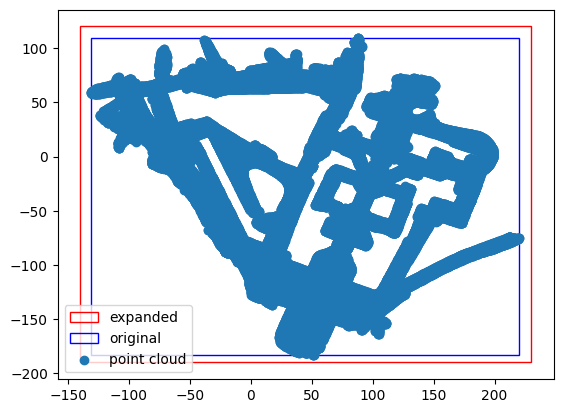

In [74]:
org_rect = patches.Polygon(abbox_coords, linewidth=1, edgecolor='b', facecolor='none')
exp_rect = patches.Polygon(expanded_boundaries, linewidth=1, edgecolor='r', facecolor='none')

fig, ax = plt.subplots()
ax.add_patch(exp_rect)
ax.add_patch(org_rect)
ax.scatter(down_points[:, 0], down_points[:, 1])
ax.legend(['expanded', 'original', 'point cloud'])
ax.plot()

In [ ]:
down_pcd.crop()

In [80]:
cbbox = o3d.geometry.AxisAlignedBoundingBox()

In [96]:
cbbox.min_bound = np.array([0, 0, 26])

In [97]:
cbbox.max_bound = np.array([10, 10, 42])

In [98]:
cropped_pcd = down_pcd.crop(cbbox)

In [99]:
cropped_pcd.get_axis_aligned_bounding_box()

AxisAlignedBoundingBox: min: (0.0047001, 0.344046, 32.5399), max: (9.53073, 9.98608, 33.4635)

In [100]:
np.asarray(cropped_pcd.points).shape

(305, 3)

In [128]:
def create_patches(min_bounds: [int, int], max_bounds: [int, int], resolution: int=10):
    x_min, y_min = min_bounds
    x_max, y_max = max_bounds
    if (x_max-x_min)%resolution !=0 or (y_max-y_min)%resolution !=0:
        raise NotImplementedError
    if (x_max==x_min) or (y_max==y_min):
        raise NotImplementedError
    bboxes = []
    for x in range(x_min, x_max, resolution):
        for y in range(y_min, y_max, resolution):
            bboxes.append([[x, y], [x+resolution, y+resolution]])
    return bboxes

In [129]:
patches = create_patches([-140, -190], [230, 120])

In [130]:
aligned_patches = []
for patch in patches:
    cbox = o3d.geometry.AxisAlignedBoundingBox()
    patch[0].append(26)
    patch[1].append(42)
    cbox.min_bound = np.array(patch[0])
    cbox.max_bound = np.array(patch[1])
    aligned_patches.append(cbox)

In [132]:
cropped_point_clouds = []
for patch in tqdm(aligned_patches):
    cpcd = pcd.crop(patch)
    cropped_point_clouds.append(cpcd)

100%|█████████████████████████████████████████| 1147/1147 [00:26<00:00, 42.88it/s]


In [145]:
filtered_cropped_point_clouds = []
for cpcd in cropped_point_clouds:
    if np.asarray(cpcd.points).shape[0]>0:
        filtered_cropped_point_clouds.append(cpcd)

In [146]:
len(filtered_cropped_point_clouds), len(cropped_point_clouds)

(509, 1147)

In [151]:
for idx, cpcd in tqdm(enumerate(filtered_cropped_point_clouds)):
    o3d.io.write_point_cloud(f"../data/patch_pcds/patch_{idx}.pcd", cpcd)

509it [00:00, 1002.02it/s]
